In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [52]:
def define_roi(img, max_display_size=800, window_name="Select ROI"):
    """
    Displays a resizable window for ROI selection, then returns the cropped ROI from the original image.

    Parameters:
    - img: np.ndarray, the original image
    - max_display_size: int, maximum width or height to resize image for display (default: 800)
    - window_name: str, name of the selection window

    Returns:
    - cropped_img: np.ndarray, the cropped region of interest from the original image
    - (x, y, w, h): tuple of ROI coordinates in the original image
    """
    orig_h, orig_w = img.shape[:2]
    scale = min(max_display_size / orig_w, max_display_size / orig_h, 1.0)

    # Resize image for easier selection
    resized_w, resized_h = int(orig_w * scale), int(orig_h * scale)
    resized_image = cv2.resize(img, (resized_w, resized_h))

    # Let user select ROI
    roi = cv2.selectROI(window_name, resized_image, showCrosshair=True, fromCenter=False)
    cv2.destroyAllWindows()

    # Convert ROI coordinates back to original scale
    x, y, w, h = roi
    x = int(x / scale)
    y = int(y / scale)
    w = int(w / scale)
    h = int(h / scale)

    cropped_img = img[y:y+h, x:x+w]
    return cropped_img, (x, y, w, h)

def hist_equalize(img):
    '''
    Histogram equalization for grayscale or color images.
    '''
    if len(img.shape) == 2:
        equalized_img = cv2.equalizeHist(img)
    else:
        channels = cv2.split(img)
        equalized_channels = [cv2.equalizeHist(ch) for ch in channels]
        equalized_img = cv2.merge(equalized_channels)

    return equalized_img

def preprocess_img(img, canny_low_thresh=30, canny_up_thresh=100):
    '''
    Convert to gray, equalize histogram, denoise using Gaussian, and detect edges
    before finding the outlines.
    '''
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    equalized = hist_equalize(gray)
    blur = cv2.bilateralFilter(equalized, d=5, sigmaColor=15, sigmaSpace=10)
    edges = cv2.Canny(blur, canny_low_thresh, canny_up_thresh)

    # New: Morphological closing to connect broken edge fragments
    
    kernel = np.ones((3, 3), np.uint8)
    closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    return closed_edges

In [40]:
def normalize_rgb_values(rgb_values, max_value=1.0):
    norm_rgb_values = (rgb_values - np.mean(rgb_values)) / np.var(rgb_values)**0.5
    norm_rgb_values += abs(np.min(norm_rgb_values))
    norm_rgb_values *= (max_value / np.max(norm_rgb_values))
    return np.round(norm_rgb_values, decimals=0).astype(int) if max_value == 255 else np.round(norm_rgb_values, decimals=9).astype(float)

def pad_image(image, _kernel):
    '''Adds zeros to image border; padded image size = image size + (2 * kernel size)'''
    _padded_image = np.zeros((image.shape[0] + _kernel.shape[0]*2, image.shape[1] + _kernel.shape[1]*2, 3)).astype(image.dtype)
    _padded_image[_kernel.shape[0]:-_kernel.shape[0], _kernel.shape[1]:-_kernel.shape[1], :] = image
    return _padded_image

def filter_image(image, _kernel):
    '''Filters image by multiplying it with kernel matrix; returns image with higher foreground values and lower background values'''
    return np.reshape(np.sum(np.reshape(image, [image.shape[0]*image.shape[1]*image.shape[2], 1])*np.reshape(_kernel, [_kernel.shape[0]*_kernel.shape[1]]), axis=1), image.shape)

def process_filtered_image(filtered_image, summed_threshold=1.5):
    '''Procsses filtered image via a summed binary threshold; returns binary 1-channel image where ones are foreground and zeros are background'''
    _processed_filtered_image = np.zeros((filtered_image.shape[0], filtered_image.shape[1])).astype(float)
    _processed_filtered_image[np.where(np.sum(filtered_image, axis=2) >= summed_threshold)] = 1.0
    if _processed_filtered_image[0, 0] == 0.0:
        _processed_filtered_image -= 1.0
        _processed_filtered_image[np.where(_processed_filtered_image == -1.0)] = 1.0
    return _processed_filtered_image

def post_process_filtered_image(processed_filtered_image, neighbors=20):
    '''Fattens object silhouette and adds borders that connect with foreground; returns same binary image but now with ones around image border and foreground features exacerbated'''
    _post_processed_filtered_image = processed_filtered_image.copy()

    def summed_neighbors(processed_filtered_image, row, col, neighbors):
        '''Sum of processed filtered image at [row, col] and neighbors (i.e. [row - neighbors:row + neighbors, col - neighbors:col + neighbors])'''
        return np.sum(processed_filtered_image[max(row - neighbors, 0):min(row + neighbors, processed_filtered_image.shape[0]), max(col - neighbors, 0):min(col + neighbors, processed_filtered_image.shape[1])])

    for row in range(processed_filtered_image.shape[0]):
        for col in range(processed_filtered_image.shape[1]):
            _post_processed_filtered_image[row, col] = 1.0 if summed_neighbors(processed_filtered_image, row, col, neighbors) > 1.0 else 0.0
    return _post_processed_filtered_image

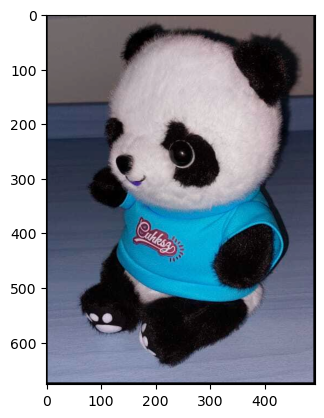

In [53]:
image = cv2.imread('../images/panda.jpg')
image, roi_points = define_roi(image)
image = normalize_rgb_values(image[:, :, :3])

_kernel = np.diag([-5.0, 2.0, 2.0])
_kernel[np.where(_kernel == 0.0)] = -1.0

image = pad_image(image, _kernel)

plt.imshow(image)
plt.show()

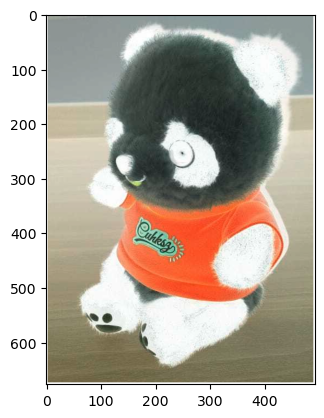

In [54]:
filtered_image = normalize_rgb_values(filter_image(image, _kernel))
plt.imshow(filtered_image)
plt.show()

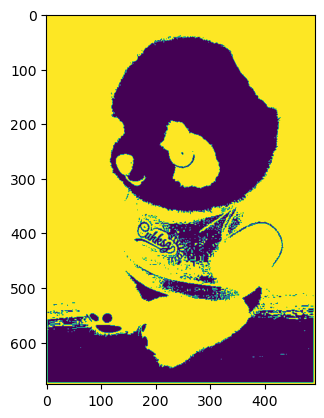

In [55]:
processed_filtered_image = process_filtered_image(filtered_image)
plt.imshow(processed_filtered_image)
plt.show()

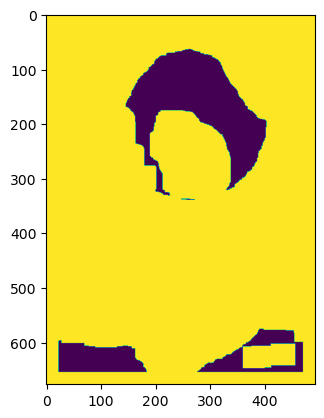

In [56]:
post_processed_filtered_image = post_process_filtered_image(processed_filtered_image)
plt.imshow(post_processed_filtered_image)
plt.show()

In [57]:
def outline_object_in_image(image, _object_silhouette_in_image, outline_color=None, outline_width=1):
    '''returns the original image but now with a bounding box around the object'''
    if outline_color is None:
        outline_color = np.array([1.0, 1.0, 1.0]).astype(float) - image[0, 0, :]

    rows, cols = np.where(_object_silhouette_in_image == 1.0)
    fill_rows = np.arange(np.min(rows), np.max(rows), 1).astype(int)
    fill_cols = np.arange(np.min(cols), np.max(cols), 1).astype(int)

    _object_outlined_in_image = image.copy()
    _object_outlined_in_image[fill_rows, np.min(cols) - outline_width:np.min(cols) + outline_width, :] = outline_color
    _object_outlined_in_image[fill_rows, np.max(cols) - outline_width:np.max(cols) + outline_width, :] = outline_color
    _object_outlined_in_image[fill_rows, int(np.round((np.max(cols) + np.min(cols))*0.5, decimals=0)) - outline_width:int(np.round((np.max(cols) + np.min(cols))*0.5, decimals=0)) + outline_width, :] = outline_color

    _object_outlined_in_image[np.min(rows) - outline_width:np.min(rows) + outline_width, fill_cols, :] = outline_color
    _object_outlined_in_image[np.max(rows) - outline_width:np.max(rows) + outline_width, fill_cols, :] = outline_color
    _object_outlined_in_image[int(np.round((np.max(rows) + np.min(rows))*0.5, decimals=0)) - outline_width:int(np.round((np.max(rows) + np.min(rows))*0.5, decimals=0)) + outline_width, fill_cols, :] = outline_color
    return _object_outlined_in_image


In [58]:
def remove_foreground(post_processed_filtered_image, image, summed_threshold=0.5):
    '''Removes foreground leaving only the object in the image (input image must already has background removed); returns same binary image but now without the foreground connecting to the borders of image
    the _object_silhouette_in_image matrix includes both forward and backward passes through the foreground of the image and those values are stored in the third dimension--the minimum sum of values that isn't zero is the object silhouette,
    which we then smooth (i.e. we draw a box around it);
    row, col, post_processed_filtered_image: forward passes;
    _row, _col, _post_processed_filtered_image: backward passes;
    '''
    _object_silhouette_in_image = np.zeros((post_processed_filtered_image.shape[0], post_processed_filtered_image.shape[1], 3)).astype(float)
    _post_processed_filtered_image = np.flip(np.flip(post_processed_filtered_image, axis=0), axis=1)
    for row, col, _row, _col in zip(np.where(post_processed_filtered_image == 1.0)[0], np.where(post_processed_filtered_image == 1.0)[1], np.where(_post_processed_filtered_image == 1.0)[0], np.where(_post_processed_filtered_image == 1.0)[1]):
        if np.mean(post_processed_filtered_image[row:, col]) < summed_threshold and np.mean(post_processed_filtered_image[row, col:]) != 1.0 or np.mean(post_processed_filtered_image[row, col:]) < summed_threshold and np.mean(post_processed_filtered_image[row:, col]) != 1.0:
            _object_silhouette_in_image[row, col, 0] = 1.0
        if np.mean(_post_processed_filtered_image[_row:, _col]) < summed_threshold and np.mean(_post_processed_filtered_image[_row, _col:]) != 1.0 or np.mean(_post_processed_filtered_image[_row, _col:]) < summed_threshold and np.mean(_post_processed_filtered_image[_row:, _col]) != 1.0:
            _object_silhouette_in_image[_row, _col, 1] = 1.0
        if np.mean(post_processed_filtered_image[row:, col]) < summed_threshold and np.mean(post_processed_filtered_image[row, col:]) < summed_threshold:
            _object_silhouette_in_image[row, col, 2] = 1.0

    def get_min_summed_object(_object_silhouette_in_image):
        '''returns the minimum summed object silhouette that isn't zero'''
        _min_sum_nums = [_object for _object in range(_object_silhouette_in_image.shape[2]) if np.sum(_object_silhouette_in_image[:, :, _object]) != 0.0]
        _object_sums_list = [_object_silhouette_in_image[:, :, 0], np.flip(np.flip(_object_silhouette_in_image[:, :, 1], axis=0), axis=1), _object_silhouette_in_image[:, :, 2]]
        _min_sum = [np.sum(_object_silhouette_in_image[:, :, _object]) for _object in _min_sum_nums]
        return _object_sums_list[np.where(_min_sum == np.min(_min_sum))[0][0]]

    def smooth_object_silhouette(_object_silhouette_in_image):
        '''returns image with a smoothed silhouette of the object; basically, it draws a box around the silhouette of the object'''
        _smoothed_object_silhouette_in_image = _object_silhouette_in_image.copy()
        rows, cols = np.where(_object_silhouette_in_image == 1.0)
        _smoothed_object_silhouette_in_image[np.min(rows):np.max(rows), np.min(cols):np.max(cols)] = 1.0
        return _smoothed_object_silhouette_in_image

    return smooth_object_silhouette(get_min_summed_object(_object_silhouette_in_image))

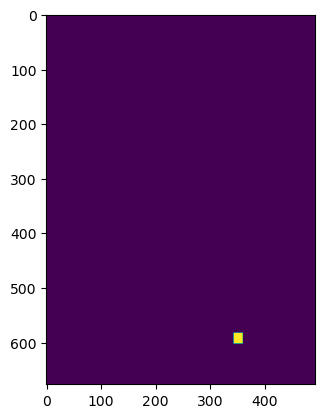

In [59]:
_object_silhouette_in_image = remove_foreground(post_processed_filtered_image, image)
plt.imshow(_object_silhouette_in_image)
plt.show()

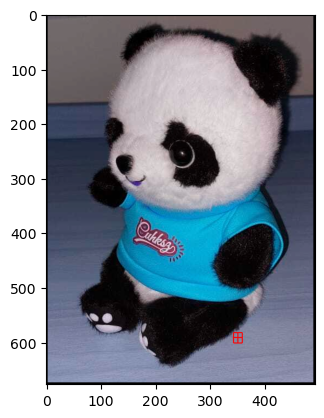

In [60]:
object_outlined_in_image = outline_object_in_image(image, _object_silhouette_in_image, outline_color=np.array([1.0, 0.0, 0.0]).astype(float))
plt.imshow(object_outlined_in_image)
plt.show()